In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.python.saved_model import tag_constants
from sklearn.metrics import confusion_matrix

C:\Projects\venv\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [3]:
train = pd.read_csv('./data/train.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


As it can be seen, there are several missing data points. Specifically, in age and cabin. 

Since, we need to predict the 'Survived' column based on other columns, we will need as much data as possible. Steps to do this:

1. See correlation between survived and other columns
2. Combine train and test dataset
3. Extract titles from names
4. Fill in missing data
    1. Age
    2. Embarked
    3. Fare
5. Add is_alone variable
6. Convert data to categorical variables
7. Normalize data to be between 0 and 1
8. Separate labels (y) from data
9. Create training and dev sets
10. Set up then neural networks to predict y
11. Create submission file and submit
12. Try Other Models - SVM and Random Forest
13. Average All Predictions

## Step 1: See correlation between survived and other columns

In [6]:
train.columns
m = train.shape[0]

Since PassengerId and name is unique to an individual, there is no relation that can be drawn with 'Survived'. 

However, Pclass, Sex, SibSp, Parch, and Embarked are categorical variables with distinct values that can impact 'Survived'.

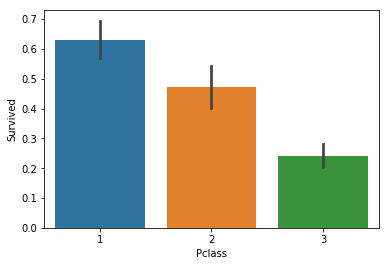

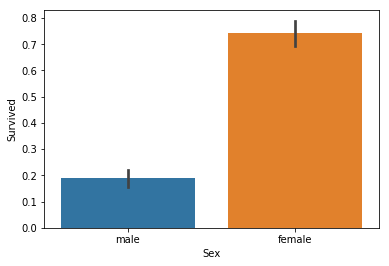

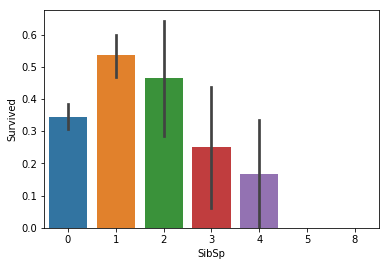

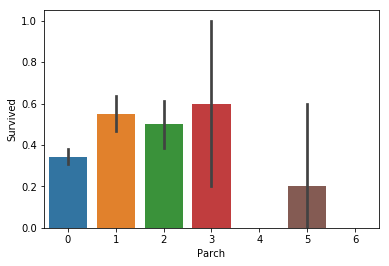

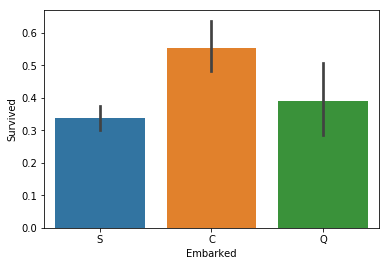

In [7]:
catCols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
j = 0
for i in catCols:
    plt.figure(j)
    sns.barplot(x = i, y = 'Survived', data = train)
    plt.show()
    j+=1

We can use all these variables as they all seem to have an impact on the survival of the passenger.

## Step 2: Combine train and test dataset

We will be transforming the training set to make it suitable for use in a machine learning model. Eg. convert string variables to categorical variables. The words 'male' and 'female' cannot be directly used for input. Instead they have to be replaced by 0 and 1 to feed to the model.

The same transformations also need to be applied on the test set because the trained model expects the input in this format. The best way to achieve this is to combine the two dataset and apply all transformations together. 

In [10]:
test = pd.read_csv('./data/test.csv')

In [12]:
dfs = [train,test]
data = pd.concat(dfs,ignore_index=True)

In [13]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


## Step 3: Extract titles from names

The names begin with certain titles - Master/Miss for children and Mr. / Mrs. for adults. These can be extracted to create a new feature using RegEx

In [14]:
def getTitles(names):
    titleRegex = re.compile(r',.\w+\.')    
    title = []
    for str in names:
        titlePat = re.search(titleRegex,str)
        if titlePat is None:
            title.append(str)
        else:
            x = titlePat.group()
            x = x[2:len(x)-1]
            title.append(x)
    return title


title = getTitles(data['Name'])

In [15]:
set(title)

{'Capt',
 'Col',
 'Don',
 'Dona',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)',
 'Sir'}

In [16]:
def getCleanTitles(title):
    for i in range(len(title)):
        if title[i] in ['Don', 'Sir', 'Jonkheer']:
            title[i] = 'Noble'
        elif title[i] in ['Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)', 'Lady', 'Dona']:
            title[i] = 'Noble'
        elif title[i] in ['Mlle', 'Ms']:
            title[i] = 'Miss'
        elif title[i] == 'Mme':
            title[i] = 'Mrs'
        elif title[i] in ['Capt', 'Col', 'Dr', 'Major', 'Rev']:
            title[i] = 'Other'
    return title

data['Title'] = getCleanTitles(title)

In [17]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


## Step 4: Fill in missing data

The more data we have available, the better the predictions can be. Hence, instead of discarding rows with data missing in some columns, we will try to fill it with some reasonable value so that the rest of the data in the row does not go to waste.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 133.0+ KB


Since Cabin has several missing values, we will not include it in our list of features. However, we can try filling in missing values in Age, Embarked and Fare.

### A. Age

Age is closely associated with Title, hence we will use the mean of ages for titles to replace missing values for rows with those titles.

In [19]:
data.groupby('Title').Age.mean()

Title
Master     5.482642
Miss      21.824366
Mr        32.252151
Mrs       36.918129
Noble     41.166667
Other     46.272727
Name: Age, dtype: float64

In [20]:
data['Age'].fillna(data.groupby('Title')['Age'].transform("mean"), inplace=True)

### B. Embarked


In [21]:
data.loc[pd.isnull(data['Embarked'])]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs


There are 2 missing values in Embarked which can be found online

In [22]:
data.loc[61,'Embarked'] = 'S'
data.loc[829,'Embarked'] = 'S'

As per this source:

https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html

https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html

### C. Fare

Fare still has one missing value. Fill it with the mean

In [23]:
data['Fare'].fillna(data['Fare'].mean(), inplace = True)

## Step 5: Add is_alone variable

The chances of survival go up for families. To find if someone is alone, we check if the sum of SibSp and Parch is 0.

In [24]:
is_alone = (data['Parch'] + data['SibSp'] == 0).astype(int)

In [25]:
data['is_alone'] = is_alone

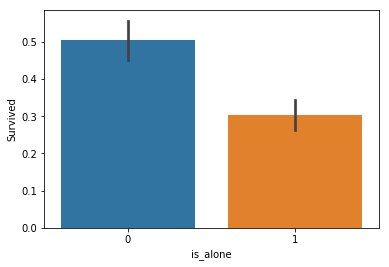

In [26]:
sns.barplot(x = 'is_alone', y = 'Survived', data = data[:m])
plt.show()

## Step 6: Convert data to categorical variables

In [27]:
data.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title', 'is_alone'],
      dtype='object')

In [28]:
catCols.extend(['Title', 'is_alone'])

In [29]:
catCols

['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title', 'is_alone']

In [30]:
def convertCatValToNum(catVal):
    le = LabelEncoder()
    le.fit(catVal)
    catVal = le.transform(catVal)
    return catVal


for i in catCols:
    data[i] = convertCatValToNum(data[i])

## Step 7: Normalize data to be between 0 and 1

Since our output is binary i.e. either 0 or 1, training a machine learning algorithm is faster when inputs are also in the same range.

In [33]:
data.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title', 'is_alone'],
      dtype='object')

Out of the above columns we will select only those we think affect the outcome i.e. 'Survived' column. 

In [34]:
Xcols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'is_alone']

In [35]:
data[Xcols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
Pclass      1309 non-null int64
Sex         1309 non-null int32
Age         1309 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Fare        1309 non-null float64
Embarked    1309 non-null int32
Title       1309 non-null int32
is_alone    1309 non-null int64
dtypes: float64(2), int32(3), int64(4)
memory usage: 76.8 KB


In [36]:
scaler = MinMaxScaler()
scaler.fit(data[Xcols])
X = scaler.transform(data[Xcols])

In [37]:
# Check if the features have been correctly scaled

X_stats = pd.DataFrame()
X_stats['Min'] = np.min(X, axis = 0)
X_stats['Max'] = np.max(X, axis = 0)
X_stats['Mean'] = np.mean(X, axis = 0)
X_stats

,Min,Max,Mean
0,0.0,1.0,0.647441
1,0.0,1.0,0.644003
2,0.0,1.0,0.372349
3,0.0,1.0,0.080851
4,0.0,1.0,0.054567
5,0.0,1.0,0.064988
6,0.0,1.0,0.746753
7,0.0,1.0,0.383652
8,0.0,1.0,0.603514


## Step 8: Separate labels (y) from data

In [38]:
y = np.expand_dims(data[:m].Survived.values,1)

In [39]:
y.shape

(891, 1)

In [ ]:
# Save preprocessed data to file

X_file = 'X.npy'
#np.save(X_file, X)

y_file = 'y.npy'
#np.save(y_file, y)

In [ ]:
# Load preprocessed data from file


#X = np.load(X_file)

#y = np.load(y_file)

## Step 9: Create training and dev sets

Validation (dev) set is useful to know how the model performs on data it has not seen. We will randomly select 10% of the data as a validation set. The test set is already provided separately by Kaggle.

In [40]:
# Set random seed

seed = 5
np.random.seed(seed)

# Get random training index

train_index = np.random.choice(m, round(m*0.9), replace=False)
dev_index = np.array(list(set(range(m)) - set(train_index)))

test_index = range(m, data.shape[0])
# Make training and dev


X_train = X[train_index]
X_dev = X[dev_index]
X_test = X[test_index]

y_train = y[train_index]
y_dev = y[dev_index]


In [41]:
y_dev.shape

(89, 1)

## Step 10: Set up neural network to predict y

In [42]:
# Initialize placeholders for data
n = X.shape[1]
x = tf.placeholder(dtype=tf.float32, shape=[None, n], name = 'inputs_ph')
y = tf.placeholder(dtype=tf.float32, shape=[None, 1], name = 'labels_ph')

In [43]:
# number of neurons in each layer

input_num_units = n
hidden_num_units = 120
output_num_units = 1

In [44]:
# Build Neural Network Weights
initializer = tf.contrib.layers.xavier_initializer()
weights = {
    'hidden1': tf.Variable(initializer([input_num_units, hidden_num_units])),
    'hidden2': tf.Variable(initializer([hidden_num_units, hidden_num_units])),
    'hidden3': tf.Variable(initializer([hidden_num_units, hidden_num_units])),
    'output': tf.Variable(initializer([hidden_num_units, output_num_units])),
}

biases = {
    'hidden1': tf.Variable(initializer([hidden_num_units])),
    'hidden2': tf.Variable(initializer([hidden_num_units])),
    'hidden3': tf.Variable(initializer([hidden_num_units])),
    'output': tf.Variable(initializer([output_num_units])),
}

In [45]:
# Build model 

keep_prob = tf.placeholder(dtype=tf.float32, name = 'keep_prob')

hidden_1_layer = tf.add(tf.matmul(x, weights['hidden1']), biases['hidden1'])
hidden_1_layer = tf.nn.dropout(tf.nn.relu(hidden_1_layer),keep_prob = keep_prob)
hidden_2_layer = tf.add(tf.matmul(hidden_1_layer, weights['hidden2']), biases['hidden2'])
hidden_2_layer = tf.nn.dropout(tf.nn.relu(hidden_2_layer),keep_prob = keep_prob)
hidden_3_layer = tf.add(tf.matmul(hidden_2_layer, weights['hidden2']), biases['hidden2'])
hidden_3_layer = tf.nn.dropout(tf.nn.relu(hidden_3_layer),keep_prob = keep_prob)

output_layer = tf.matmul(hidden_3_layer, weights['output']) + biases['output']


In [46]:
# Set hyperparameters

learning_rate = 3e-4
epochs = 4000

In [47]:
# Set loss function and goal i.e. minimize loss

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=output_layer, labels=y))
opt = tf.train.AdamOptimizer(learning_rate)
goal = opt.minimize(loss)

In [48]:
prediction = tf.round(tf.nn.sigmoid(output_layer), name = 'prediction')
correct = tf.cast(tf.equal(prediction, y), dtype=tf.float32)
recall = tf.metrics.recall(labels = y, predictions = prediction)
accuracy = tf.reduce_mean(correct)

In [49]:
# Initialize lists to store loss and accuracy while training the model

loss_trace = []
train_acc = []
dev_acc = []

In [50]:
# Start tensorflow session

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [51]:
# Train the model

for epoch in range(epochs):
    
    sess.run(goal, feed_dict={x: X_train, y: y_train, keep_prob: 0.5})

    # calculate results for epoch

    temp_loss = sess.run(loss, feed_dict={x: X_train, y: y_train, keep_prob: 1})
    temp_train_acc = sess.run(accuracy, feed_dict={x: X_train, y: y_train, keep_prob: 1})
    temp_dev_acc = sess.run(accuracy, feed_dict={x: X_dev, y: y_dev, keep_prob: 1})

    # save results in a list

    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    dev_acc.append(temp_dev_acc)

    # output

    if (epoch + 1) % 200 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} dev_acc: {:5f}'.format(epoch + 1, temp_loss, temp_train_acc, temp_dev_acc))



epoch:  200 loss: 0.430971 train_acc: 0.811721 dev_acc: 0.685393
epoch:  400 loss: 0.403263 train_acc: 0.825436 dev_acc: 0.741573
epoch:  600 loss: 0.386479 train_acc: 0.844140 dev_acc: 0.764045
epoch:  800 loss: 0.375715 train_acc: 0.849127 dev_acc: 0.764045
epoch: 1000 loss: 0.368498 train_acc: 0.847880 dev_acc: 0.775281
epoch: 1200 loss: 0.363852 train_acc: 0.849127 dev_acc: 0.775281
epoch: 1400 loss: 0.358967 train_acc: 0.849127 dev_acc: 0.764045
epoch: 1600 loss: 0.354462 train_acc: 0.850374 dev_acc: 0.775281
epoch: 1800 loss: 0.349524 train_acc: 0.852868 dev_acc: 0.764045
epoch: 2000 loss: 0.345011 train_acc: 0.854115 dev_acc: 0.775281
epoch: 2200 loss: 0.340378 train_acc: 0.857855 dev_acc: 0.775281
epoch: 2400 loss: 0.336085 train_acc: 0.856608 dev_acc: 0.775281
epoch: 2600 loss: 0.331282 train_acc: 0.859102 dev_acc: 0.775281
epoch: 2800 loss: 0.326550 train_acc: 0.864090 dev_acc: 0.764045
epoch: 3000 loss: 0.321738 train_acc: 0.864090 dev_acc: 0.775281
epoch: 3200 loss: 0.31681

## Step 11: Create submission file and submit

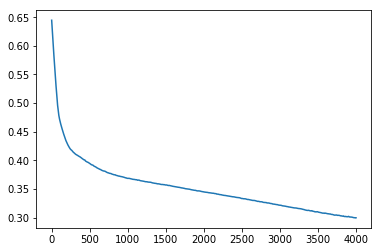

In [52]:
plt.plot(loss_trace)

In [53]:
y_train_preds_nn = sess.run(prediction, feed_dict ={x: X_train, keep_prob: 1})
y_dev_preds_nn = sess.run(prediction, feed_dict ={x: X_dev, keep_prob: 1})
y_test_preds_nn = sess.run(prediction, feed_dict ={x: X_test, keep_prob: 1})

In [54]:
# Save model for future predictions

inputs_dict = {'inputs_ph': x, 'labels_ph': y, 'keep_prob': keep_prob}
outputs_dict = {'prediction': prediction}
tf.saved_model.simple_save(sess, 'simple', inputs_dict, outputs_dict)

Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: simple\saved_model.pb


In [55]:
sess.close()

In [56]:
# Restore saved model

graph = tf.get_default_graph()
with tf.Session(graph = graph) as sess:
    # Restore saved values
    print('\nRestoring...')
    tf.saved_model.loader.load(sess, [tag_constants.SERVING], 'simple')
    print('Ok')
    # Get restored placeholders
    x = graph.get_tensor_by_name('inputs_ph:0')
    keep_prob = graph.get_tensor_by_name('keep_prob:0')
    
    # Get restored model output
    prediction = graph.get_tensor_by_name('prediction:0')

    # Initialize restored dataset
    y_train_preds_nn_saved = sess.run(prediction, feed_dict={x: X_train, keep_prob: 1})
    y_test_preds_nn_saved = sess.run(prediction, feed_dict={x: X_test, keep_prob: 1})


Restoring...
INFO:tensorflow:Restoring parameters from simple\variables\variables
Ok


In [57]:
# Check if original and restored predictions are same

confusion_matrix(y_train_preds_nn_saved, y_train_preds_nn)

array([[545,   0],
       [  0, 257]], dtype=int64)

Since the confusion matrix only has diagonal elements, the predictions match.

In [58]:
def get_recall(labels, preds):
    tp = int(np.dot(labels.T,preds))
    fn = int(np.dot(labels.T,1-preds))
    recall = tp/(tp+fn)
    return recall

In [59]:
recall_nn = get_recall(y_train, y_train_preds_nn)
recall_nn

0.7467532467532467

In [60]:
test['Survived_nn'] = y_test_preds_nn.astype(int)

In [61]:
test[['PassengerId', 'Survived_nn']].to_csv('submission_nn.csv', index = False, header = ['PassengerId', 'Survived'])

## Step 12: Try Other Models - SVM and Random Forest

In [62]:
svclassifier = SVC()
svclassifier.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [63]:
y_train_preds_svm = np.expand_dims(svclassifier.predict(X_train),1)
train_acc_svm = np.mean(y_train == y_train_preds_svm)
print('Train Accuracy for SVM: {:5f}'.format(train_acc_svm))

Train Accuracy for SVM: 0.795511


In [66]:
y_test_preds_svm = svclassifier.predict(X_test)

In [64]:
recall_svm = get_recall(y_train, y_train_preds_svm)
recall_svm

0.6883116883116883

In [67]:
test['Survived_svm'] = y_test_preds_svm.astype(int)

In [68]:
test[['PassengerId', 'Survived_svm']].to_csv('submission_svm.csv', index = False, header = ['PassengerId', 'Survived'])

In [69]:
rfclassifier = RandomForestClassifier(n_estimators = 100, max_features = 4)
rfclassifier.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [70]:
y_train_preds_rf = np.expand_dims(rfclassifier.predict(X_train),1)
train_acc_rf = np.mean(y_train == y_train_preds_rf)
print('Train Accuracy for Random Forest: {:5f}'.format(train_acc_rf))

Train Accuracy for Random Forest: 0.985037


In [71]:
y_dev_preds_rf = np.expand_dims(rfclassifier.predict(X_dev),1)
dev_acc_rf = np.mean(y_dev == y_dev_preds_rf)
print('Dev Accuracy for Random Forest: {:5f}'.format(dev_acc_rf))

Dev Accuracy for Random Forest: 0.764045


In [77]:
recall_rf = get_recall(y_train, y_train_preds_rf)
recall_rf

0.974025974025974

In [72]:
y_test_preds_rf = rfclassifier.predict(X_test)

In [73]:
test['Survived_rf'] = y_test_preds_rf.astype(int)

In [74]:
test[['PassengerId', 'Survived_rf']].to_csv('submission_rf.csv', index = False, header = ['PassengerId', 'Survived'])

# Step 13: Average All Predictions

In [78]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived_nn', 'Survived_svm',
       'Survived_rf', 'Survived_nn_wtd', 'Survived_svm_wtd'],
      dtype='object')

In [79]:
test['Survived_nn_wtd'] = test['Survived_nn']*recall_nn
test['Survived_svm_wtd'] = test['Survived_svm']*recall_svm
test['Survived_rf_wtd'] = test['Survived_nn']*recall_rf

In [80]:
y_test_preds_avg = np.round(np.mean(test[['Survived_nn', 'Survived_svm','Survived_rf']],axis = 1))

In [81]:
y_test_preds_wtd_avg = np.round(np.mean(test[['Survived_nn_wtd', 'Survived_svm_wtd','Survived_rf_wtd']],axis = 1))

In [82]:
test['Survived_avg'] = y_test_preds_avg.astype(int)

In [83]:
test['Survived_wtd_avg'] = y_test_preds_wtd_avg.astype(int)

In [84]:
test[['PassengerId', 'Survived_avg']].to_csv('submission_avg.csv', index = False, header = ['PassengerId', 'Survived'])

In [85]:
test[['PassengerId', 'Survived_wtd_avg']].to_csv('submission_wtd_avg.csv', index = False, header = ['PassengerId', 'Survived'])